# Introduction
This notebook implements a simple GAN network of 1D latent space.
The GAN learns a predefined data distribution $P_{Data}(x)$ and generates data from a learned distibution  $P_{model}(x)$ which is very close to the real data distribution.
The implementation was done based on the example found in the below link:

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#end-to-end_example_a_gan_training_loop_from_scratch

In [1]:
import numpy
import tensorflow as tf
from tensorflow import keras 
from keras import layers, Sequential


### Model Parameters
iterations = 7000
mean= 7 ; stddev= 2 # Real data mean & standard deviation
batch_size= 256
d_learning_rate=0.003
g_learning_rate=0.005
k = 2 # K parameter described in the algorithm (line3, page 17 in the slide23)
reporting_step=1000 # used to draw the gaphs at these steps

### Build the custom Layers
xavier_init = tf.keras.initializers.GlorotNormal(seed=1)
class Discriminator (layers.Layer):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.WD0 = self.add_weight("WD0",shape=(1,1),initializer=xavier_init)
        self.WD1 = self.add_weight("WD1",shape=(1,1),initializer=xavier_init)
        self.WD2 = self.add_weight("WD2",shape=(1,1),initializer=xavier_init)
    def call(self, x):
        D = tf.math.sigmoid( self.WD0 + self.WD1*x + self.WD2 * (x**2))
        return D

class Generator (layers.Layer):
    def __init__(self):
        super(Generator, self).__init__()
        self.WG0 = self.add_weight("WG0",shape=(1,1),initializer=xavier_init)
        self.WG1 = self.add_weight("WG1",shape=(1,1),initializer=xavier_init)
        # self.WG0 = mean-1
        # self.WG1 = stddev
        
    def call(self, z):
        G = tf.math.add(self.WG0,self.WG1*z)
        return G

input = tf.keras.Input(shape=(1))
output = Discriminator()(input)

D = tf.keras.Model(input, output)
D.summary()

input = tf.keras.Input(shape=(1))
output = Generator()(input)

G = tf.keras.Model(input, output)
G.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 discriminator (Discriminato  (None, 1)                3         
 r)                                                              
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 generator (Generator)       (None, 1)                 2         
                                                  

In [2]:
# Instantiate one optimizer for the discriminator and another for the generator.
d_optimizer = keras.optimizers.Adam(learning_rate=d_learning_rate)
g_optimizer = keras.optimizers.Adam(learning_rate=g_learning_rate)

# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)


In [3]:
#### Customized Training loop
@tf.function
def train_step(training_images):
    for step in range(k):  
        #### 1. Discriminator forward pass
        # Sample random mini-batch of samples in the latent space
        z = tf.random.normal(shape=(batch_size, 1))
        # Decode them to fake images
        fake_images = G(z)

        # build a mini-batch of real images for one iteration of k
        start_image=step*batch_size
        end_image =start_image+batch_size-1
        real_images = training_images[start_image:end_image]
        #real_images = training_images
        # Combine them with real images
        combined_images = tf.concat([fake_images,real_images], axis=0)

        # assemble labels (0 for fake images and 1 for real images)
        # we train discriminator to differentiate between fake & real images 
        d_labels = tf.concat([tf.zeros((fake_images.shape[0], 1)), 
                            tf.ones((real_images.shape[0], 1))], axis=0)

        with tf.GradientTape() as tape:
            predictions = D(combined_images)
            d_loss = loss_fn(d_labels, predictions)        

        #### 2. Discriminator backword pass
        grads = tape.gradient(d_loss, D.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, D.trainable_weights))

    #### 3. Generator forward pass
    # Sample random points in the latent space
    z = tf.random.normal(shape=(batch_size, 1))
    # assemble labels (all 0's)
    # we train the generator to generate images which the discriminator 
    # should classify as real images) ==> labels are ones (real images)
    g_labels = tf.ones((batch_size, 1)) 

    #### 4. Generator forward pass (all computations should be within the tape)
    with tf.GradientTape() as tape: 
        predictions = D(G(z))
        g_loss = loss_fn(g_labels, predictions)

    #### 4. Generator backword pass
    grads = tape.gradient(g_loss, G.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, G.trainable_weights))

    return d_loss, g_loss, G(z)

In [4]:
import numpy as np
from numpy import linspace

D_loss=[]
G_loss=[]
generated_images_list=[]
prediction_list = []
x = np.linspace(-5, 10, 300)
for iteration in range(iterations+1):
    real_images = tf.random.normal(shape=(batch_size*k, 1),mean=mean,stddev=stddev)
    d_loss, g_loss, generated_images = train_step(real_images)
    D_loss.append(d_loss)
    G_loss.append(g_loss)
    if (iteration%reporting_step==0):
      print("\nStart of iteration=%d"%(iteration))
      #print("Discriminator loss: %.2f" % (d_loss))
      #print("Generator loss: %.2f" % (g_loss))
      generated_images_list.append(generated_images)
      prediction_list.append(D(x))
      #print(D.trainable_weights)

    if (iteration%10==0):
      print(".",end ="")


Start of iteration=0
....................................................................................................
Start of iteration=1000
....................................................................................................
Start of iteration=2000
....................................................................................................
Start of iteration=3000
....................................................................................................
Start of iteration=4000
....................................................................................................
Start of iteration=5000
....................................................................................................
Start of iteration=6000
....................................................................................................
Start of iteration=7000
.

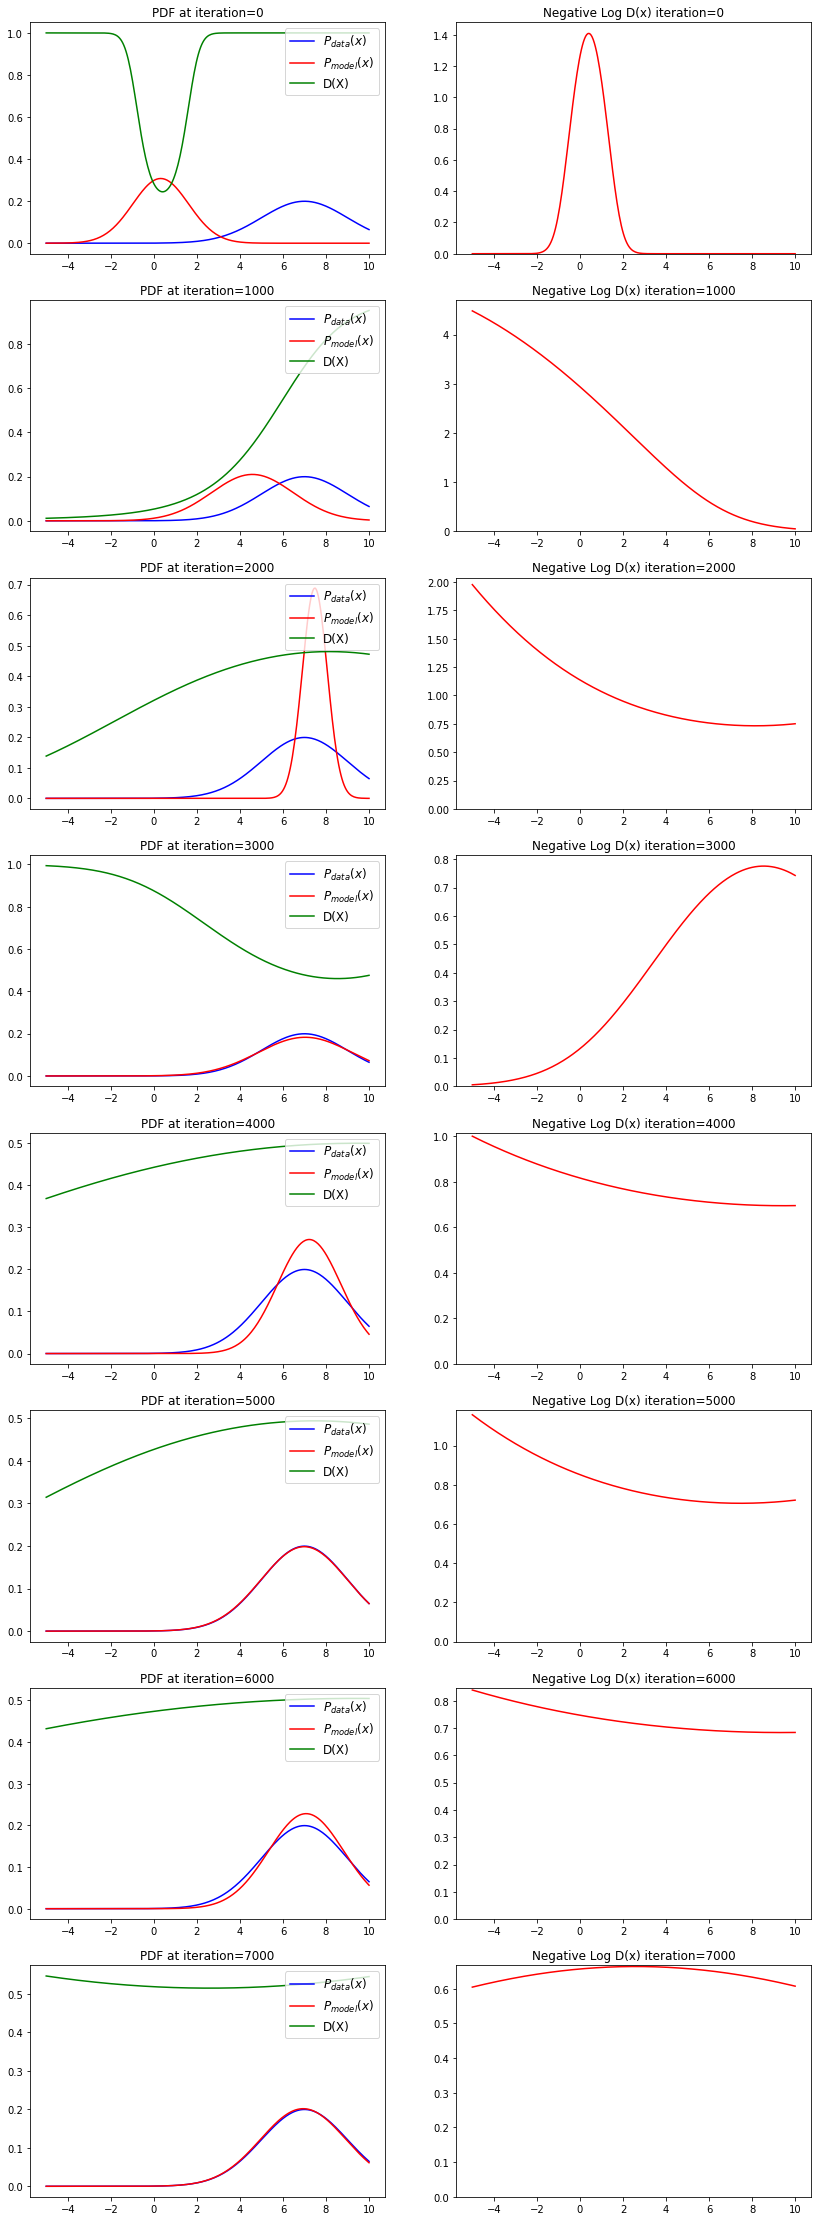

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.lib.scimath import log


real_images_pdf = norm.pdf(x, mean, stddev)
numOfResults = len(generated_images_list)
plt.figure(figsize=(14,numOfResults*5))

plot_index=1
# x_axis1=range(len(D_loss))
# plt.subplot(numOfResults/3+1, 3, 1)
# plt.plot(x_axis1, D_loss, label='Discriminator Loss')
# plt.plot(x_axis1, G_loss, label='Generator Loss')
# plt.legend(loc='upper right')
# plt.title('Loss Values')
# plot_index=plot_index+1


for i in range(len(generated_images_list)):
  plt.subplot(numOfResults, 2, plot_index)
  plt.title('PDF at iteration=%d'%(i*reporting_step))
  mu, std = norm.fit(generated_images_list[i].numpy().reshape(-1))
  generated_images_pdf = norm.pdf(x, mu, std)
  plt.plot(x,real_images_pdf,'b',label=r'$P_{data}(x)$')
  plt.plot(x,generated_images_pdf,'r',label=r'$P_{model}(x)$')
  plt.plot(x,prediction_list[i],'g',label='D(X)')
  plt.legend(loc='upper right',fontsize=12)
  plot_index=plot_index+1


  plt.subplot(numOfResults, 2, plot_index)
  plt.title('Negative Log D(x) iteration=%d'%(i*reporting_step))
  plt.plot(x,-1*log(prediction_list[i]),'r',label='Negative Log (D(x))')
  plt.ylim(bottom=0)
  plot_index=plot_index+1



plt.show()